In [70]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from __future__ import division
from sklearn.decomposition import PCA
def parser(x):
    return pd.datetime.strptime('2015'+x, '%Y%d/%m/%H %M')

data = read_csv('./BATADAL_dataset03.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)
data.drop(['ATT_FLAG'],axis=1)
series = data.copy()

In [59]:
import custom_function as cf

/usr/local/lib/python2.7/dist-packages/pyemma/__init__.py:134: UserWarning: Python 2.7 usage is deprecated. Future versions of PyEMMA will not support it. Please upgrade your Python installation.
  "Please upgrade your Python installation.", category=UserWarning)


In [60]:
data['L_T3'].mean()

4.201820402627554

In [61]:
# definition of the different state
x1 = (data['L_T3'] <=3).astype(int)
x2= ((data['L_T3'] > 3) & (data['L_T3']<=3.5)).astype(int)
x3 = ((data['L_T3'] > 3.5) & (data['L_T3']<=4)).astype(int)
x4 = ((data['L_T3'] > 4) & (data['L_T3']<=4.5)).astype(int)
x5 = ((data['L_T3'] > 4.5) & (data['L_T3']<=5)).astype(int)
x6 = (data['L_T3'] >5).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5 + 6*x6



In [62]:
# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = cf.markovAnomaly(df_mm, 10, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    8756
1       5
dtype: int64


In [63]:
data['anomaly24'] = df_anomaly

In [64]:
# SAX discritization
from saxpy import SAX
s = SAX(3, 3, 1e-6)
(x3Strings, x3Indices) = s.sliding_window(data['L_T3'], 350, 0.01)

365
365
3


In [65]:
X=np.array(range(len(data)))
data.insert(0, 'SAX_value', X)

sax_data=pd.DataFrame(x3Indices,x3Strings )
str_set=set(x3Strings)

print type(str_set)
for i,item in enumerate(str_set):
    start=np.array(sax_data.loc[item][0])
    end=np.array(sax_data.loc[item][1])
    #print item,i
    for j in xrange(len(start)):
        #print j
        data['SAX_value'][range(start[j],end[j])]=i
    

<type 'set'>


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
sax_anomaly = cf.markovAnomaly(data['SAX_value'], 30, 0.20)
sax_anomaly = pd.Series(sax_anomaly)
print(sax_anomaly.value_counts())

1    8711
0      50
dtype: int64


In [ ]:
data2

# PCA analysis

1.Normalization

In [71]:
my_data=data.drop(['ATT_FLAG'],axis=1)
my_data=my_data.dropna(axis=0,how='any')
X_train = my_data.iloc[:, :].values
print my_data.shape
#standardize the training data
def standardize_(X_train):
    for c in range(X_train.shape[1]):
        x_std=X_train[:,c].std()
        x_mean=X_train[:,c].mean()
        scaler=StandardScaler().fit(X_train)
        if x_std !=0:
            #print x_mean
            X_train[:,c] = (X_train[:,c]-x_mean)

    return X_train
X_train=standardize_(X_train)
sum(X_train[:,0])

(8761, 43)


-2.119637798614349e-12

In [72]:
from sklearn.decomposition import PCA
myModel=PCA(n_components=15)
low_data=myModel.fit_transform(X_train)
print X_train.shape

print 'This model captures {:0.0%} of variance'.format(sum(myModel.explained_variance_ratio_))

(8761, 43)
This model captures 100% of variance


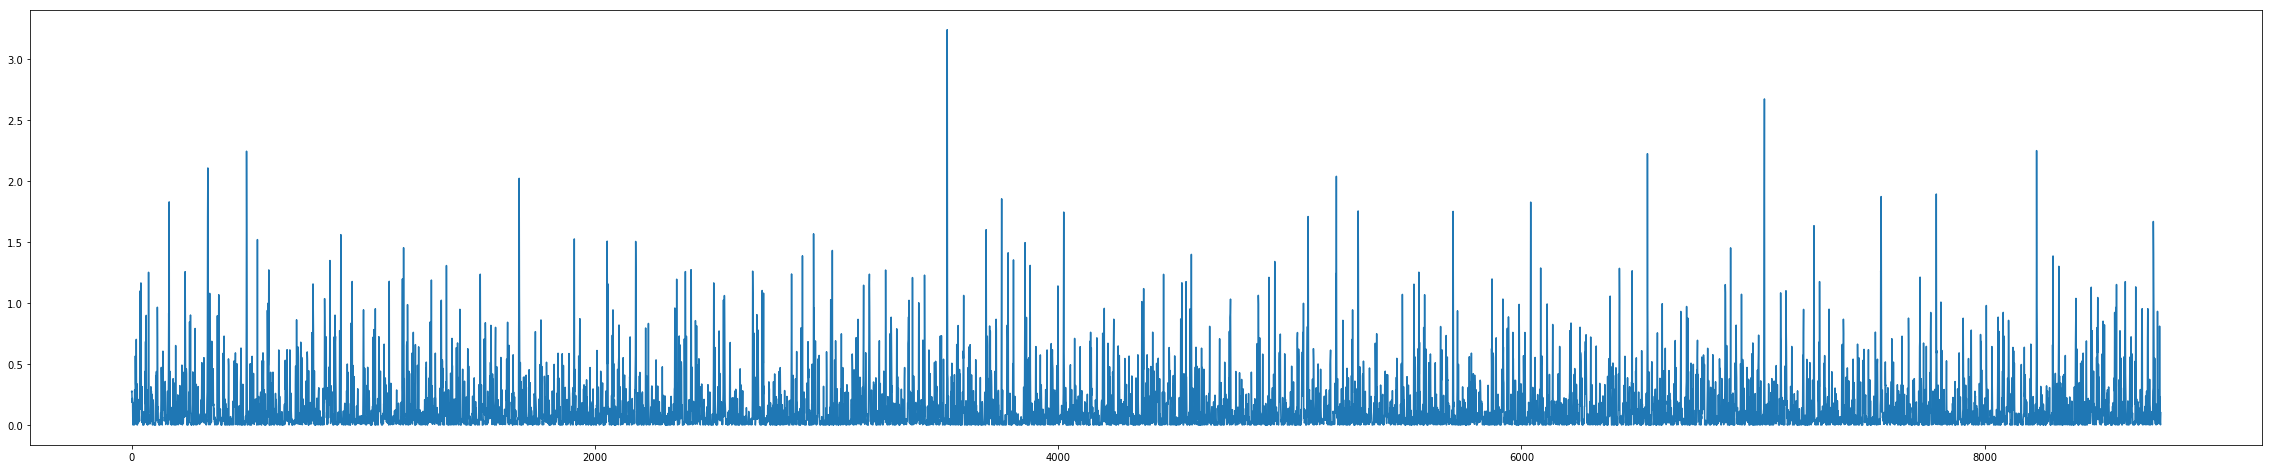

In [73]:
restore_data=myModel.inverse_transform(low_data)
res=np.array(X_train-restore_data)  # compute the residual
signal1=np.square(res[:,2])   # pick one certain signal to visualize the residual

plt.figure(figsize=(40,8))
plt.plot(signal1)


In [75]:
sum(signal1>1)

134

# optimize with dataset 2

In [30]:
data2 = read_csv('./BATADAL_dataset04.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)
label=data2[' ATT_FLAG']
data2=data2.drop([' ATT_FLAG'],axis=1)
my_data2=data2.dropna(axis=0,how='any')
X_val = my_data2.iloc[:, :].values
X_val = standardize_(X_val)

In [32]:
myModel=PCA(n_components=8)
low_data2=myModel.fit_transform(X_val)
print X_val.shape

print 'This model captures {:0.0%} of variance'.format(sum(myModel.explained_variance_ratio_))

(4177, 43)
This model captures 99% of variance


array([0., 0., 0., ..., 0., 0., 0.])

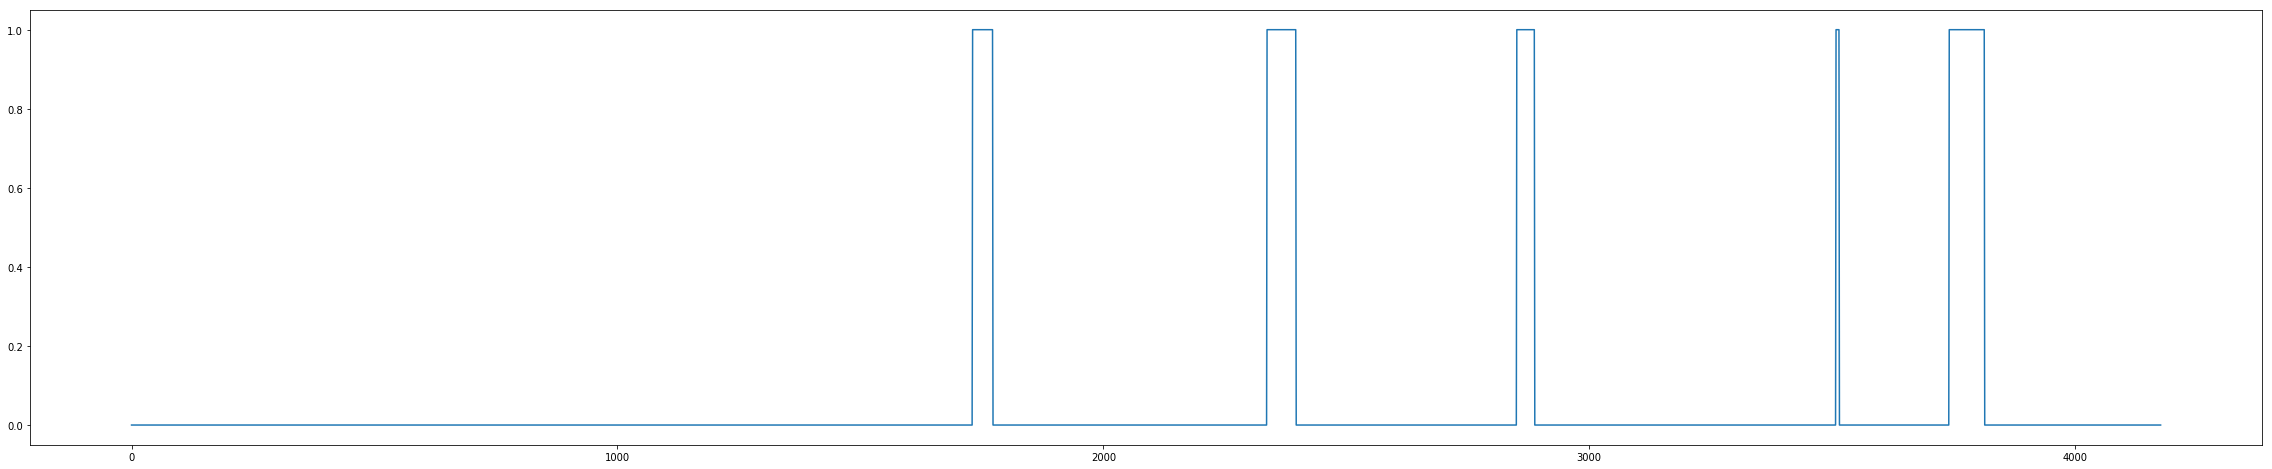

In [33]:
#visulize the labels
label=np.array(label+999)/999
plt.figure(figsize=(40,8))
plt.plot(label)
label

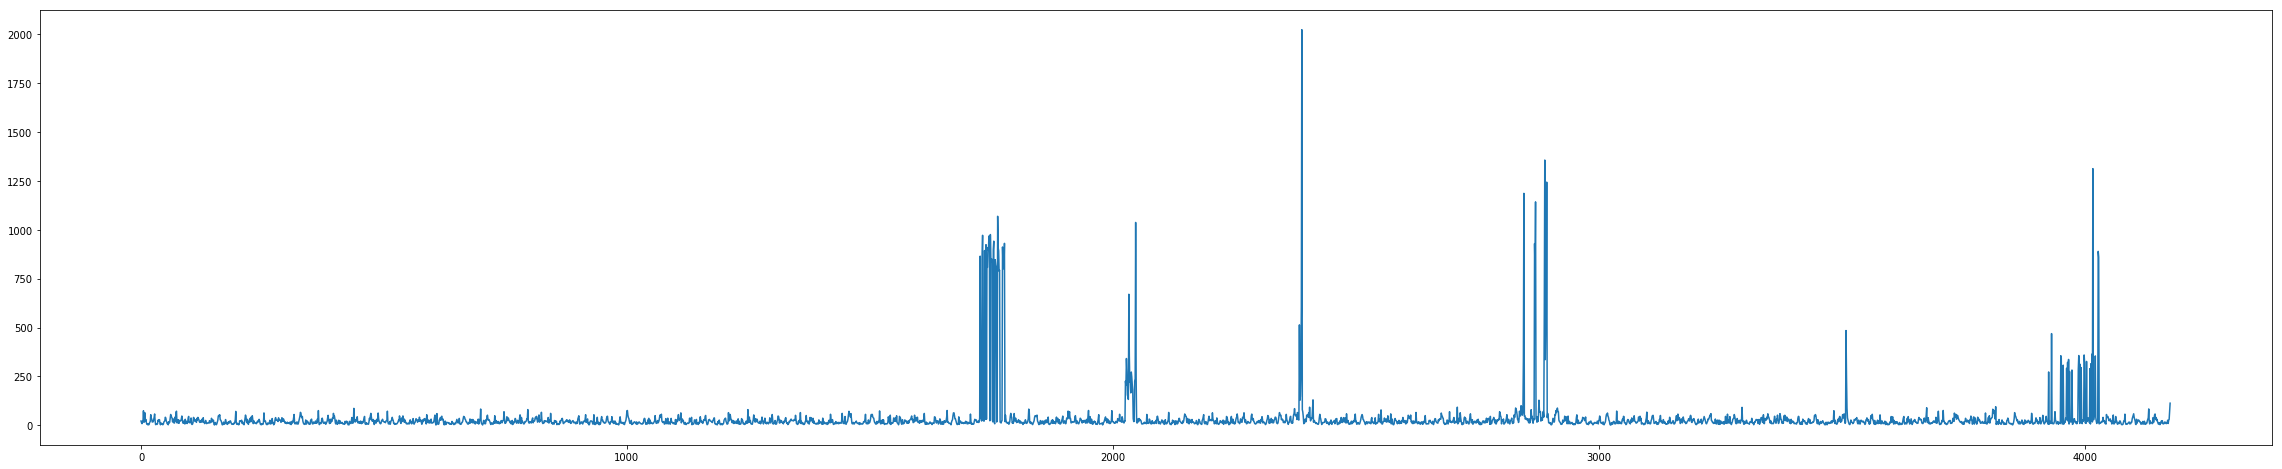

In [34]:
restore_data2 = myModel.inverse_transform(low_data2) #restore data from pca
res2 = np.array(X_val-restore_data2)  # compute the residual
residual2 = np.sum(np.square(res2),axis=1)  #compute overall residuals
#signal2 = np.square(res2[:,2])   # pick one certain signal to visualize the residual

plt.figure(figsize=(40,8))
plt.plot(residual2)

In [35]:
len(residual2),len(label)
residual2

array([ 22.20071457,  13.93988205,   8.76026235, ...,  30.90186508,
        73.81890035, 113.33647815])

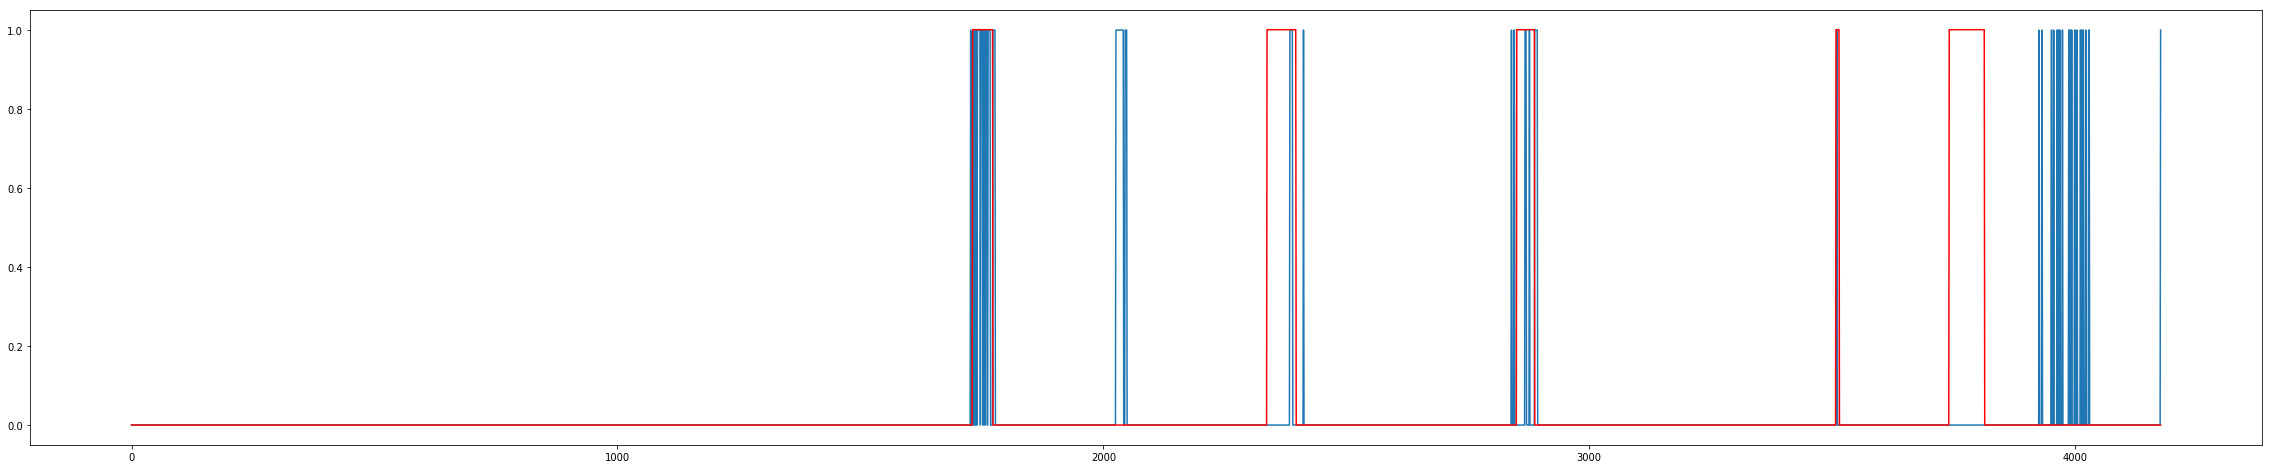

In [36]:
prediction=(residual2>100)*1
plt.figure(figsize=(40,8))
plt.plot(prediction)
plt.plot(label,'r')

In [38]:
from sklearn.metrics import confusion_matrix
#  true negatives  false positives
#  false negatives  true positives
cm=confusion_matrix(label.astype(int),prediction)

recall = cm[1][1]/(cm[0][1]+cm[1][1])
print recall

0.3673469387755102


In [39]:
# get the eigen vectors for testing
evecs=myModel.components_
evecs.shape

(8, 43)

# test on dataset_test

In [40]:
data3 = read_csv('./BATADAL_test_dataset.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)
my_data3=data3.dropna(axis=0,how='any')
X_test = my_data3.iloc[:, :].values

In [41]:
X_test=standardize_(X_test)

((2089, 43), (8, 43))

(2089, 8)
(2089, 43)


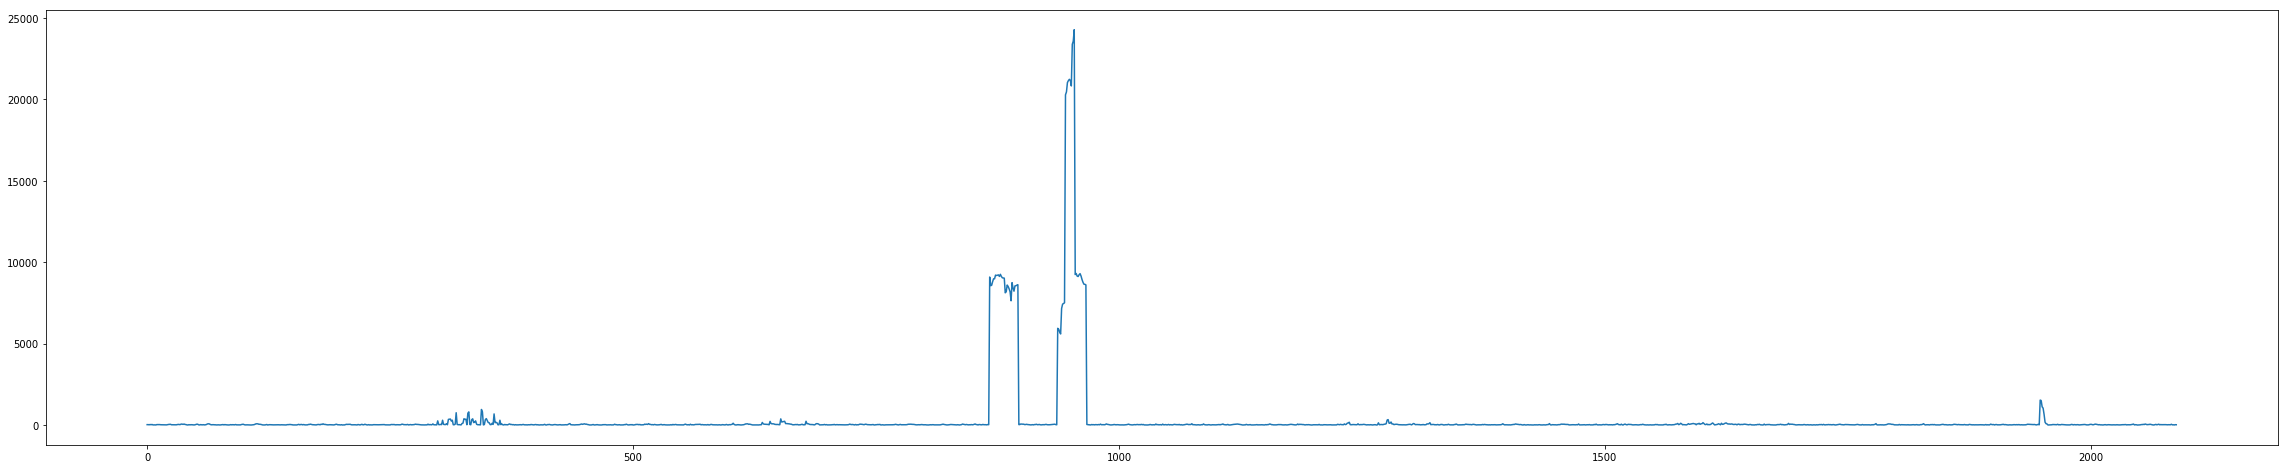

In [42]:
low_test=np.dot(X_test,evecs.T)
print low_test.shape
reconstruct=np.dot(low_test, evecs)
print reconstruct.shape
residual_test=X_test-reconstruct
residuals2 = np.sum(np.square(residual_test),axis=1)
plt.figure(figsize=(40,8))
plt.plot(residuals2)

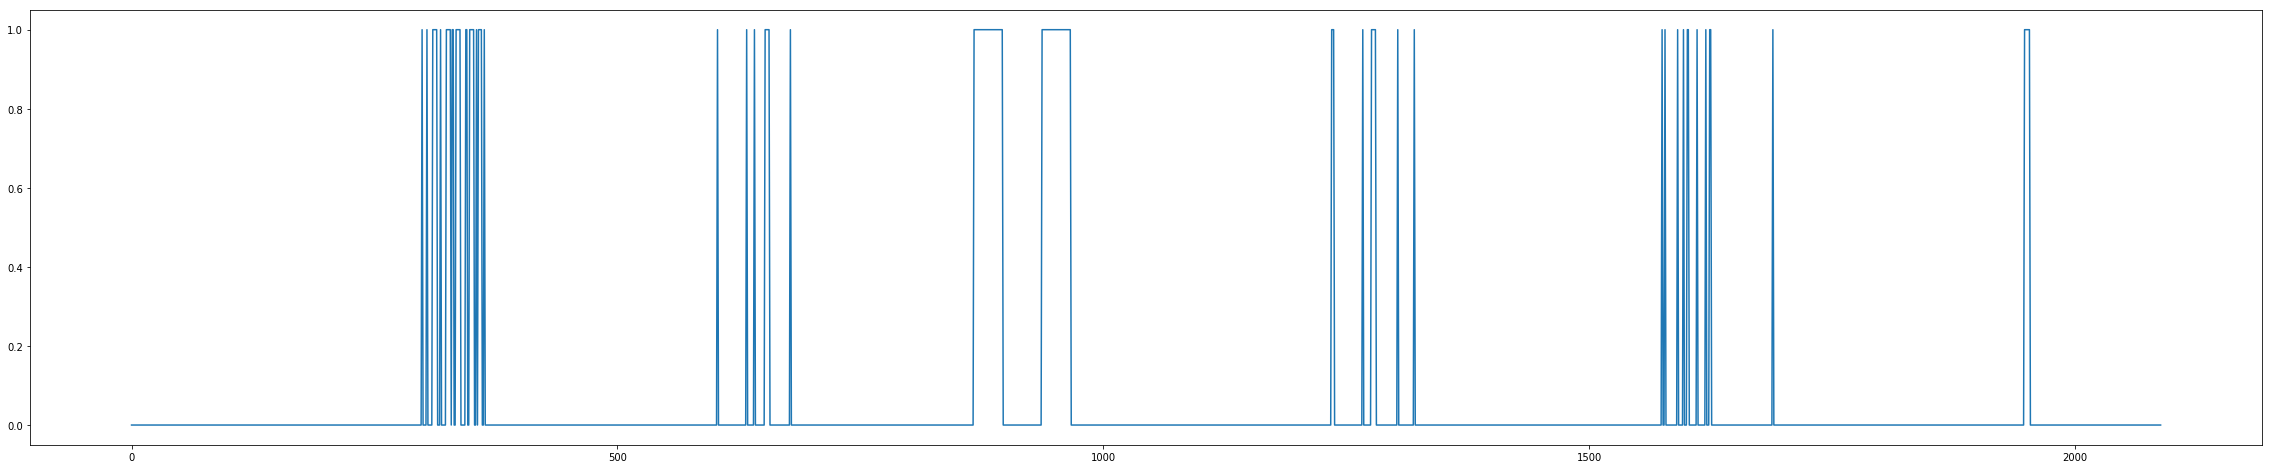

In [43]:
# plot the decision result
prediction_test=(residuals2>100)*1
plt.figure(figsize=(40,8))
plt.plot(prediction_test)

# Convert test labels

In [44]:
def parser2(x):
    return pd.datetime.strptime('2017'+x, '%Y%d/%m/%H %M')

data3 = read_csv('./BATADAL_test_dataset.csv', header=0, parse_dates=[0], squeeze=True,\
                  date_parser=parser2)
data3['label']=0
attack_info=['2017-01-16 17:09:00',70],['2017-01-30 17:08:00',65], ['2017-02-09 17:03:00',31],\
            ['2017-02-12 17:01:00',31],['2017-02-24 17:05:00',100],['2017-03-10 17:14:00',80],['2017-03-25 17:20:00',30]
for attack in attack_info:

    start_date = attack[0]
    duration = np.array(attack[1])
    
    a_index=data3[(data3.DATETIME==start_date)].index
    a_index=np.array(a_index)[0]
    
    data3.iloc[range(a_index,a_index+duration),-1]=1
    
label=np.array(data3['label'])  #get lables

0.9846153846153847


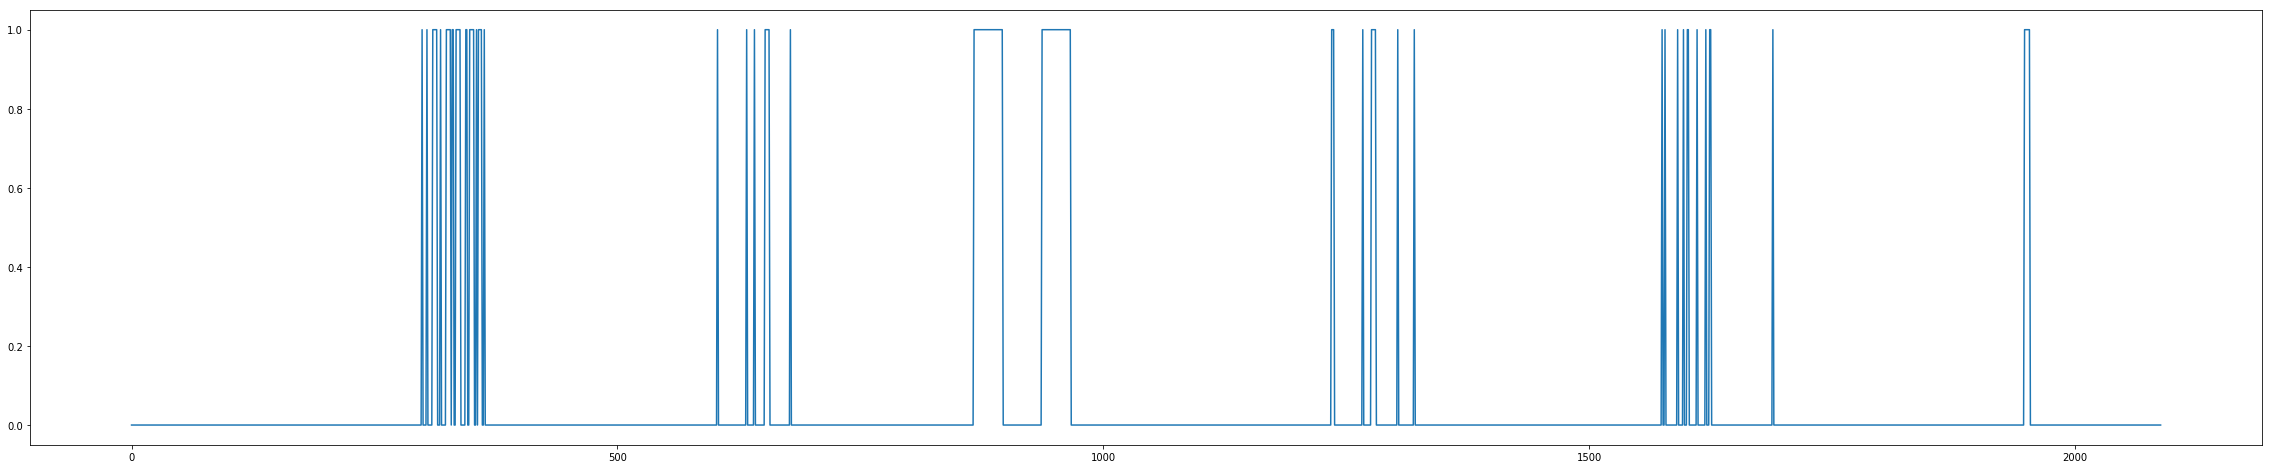

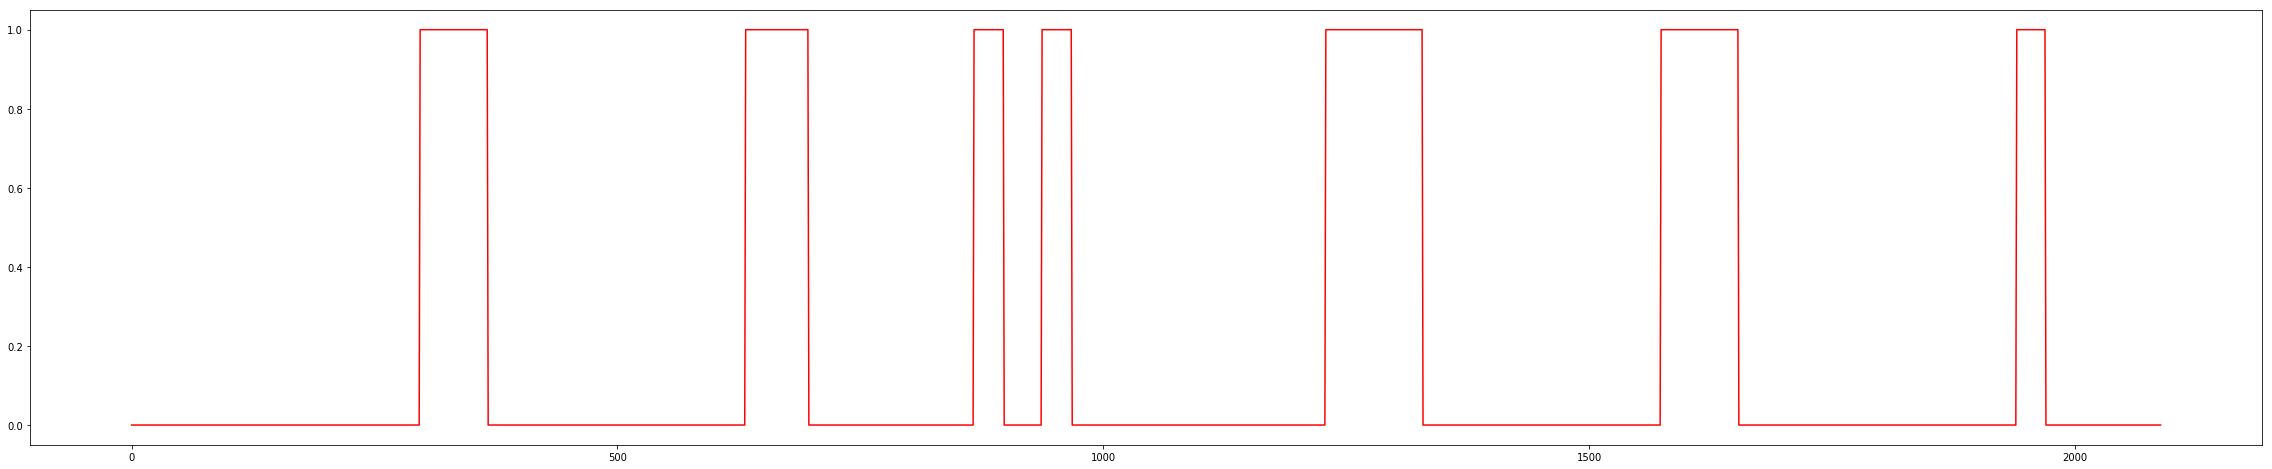

In [56]:
cm=confusion_matrix(label.astype(int),prediction_test)

recall = cm[1][1]/(cm[0][1]+cm[1][1])

print recall

plt.figure(figsize=(40,8))
plt.plot(prediction_test)
plt.figure(2)
plt.figure(figsize=(40,8))
plt.plot(label,'r')

In [57]:
cm

array([[1680,    2],
       [ 279,  128]])